In [140]:
import torch
from torchvision.datasets import VOCDetection
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms.functional import to_tensor, to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [2]:
# VOC 2007 dataset을 저장할 위치
path2data = './data'
if not os.path.exists(path2data):
    os.mkdir(path2data)

In [25]:
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

In [141]:
class MyCustomDatasets(VOCDetection):
    def __getitem__(self, idx):
        img = np.array(Image.open(self.images[idx]).convert('RGB'))
        target = self.parse_voc_xml(ET.parse(self.annotations[idx]).getroot())

        coordinates = []
        labels = []

        for obj in target['annotation']['object']:
            coordinates.append([int(val) for key, val in obj['bndbox'].items()])
            labels.append(classes.index(obj['name']))

        if self.transforms:
            img = self.transforms(img)
            coordinates = torch.LongTensor(coordinates)
            labels = torch.LongTensor(labels)

        return img, coordinates, labels


In [142]:
train_ds = MyCustomDatasets(path2data, year='2007', 
                            image_set='train', download=True, 
                            transforms=transforms.Compose([transforms.ToTensor()]))
val_ds = MyCustomDatasets(path2data, year='2007', 
                          image_set='test', download=True,
                          transforms=transforms.Compose([transforms.ToTensor()]))

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtest_06-Nov-2007.tar
Extracting ./data/VOCtest_06-Nov-2007.tar to ./data


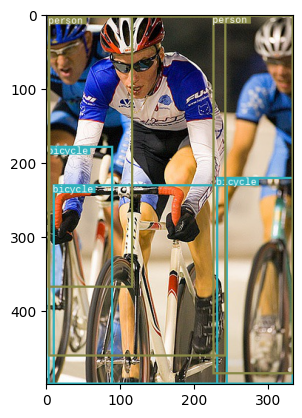

In [147]:
img, coordinates, labels = train_ds[2]
colors = np.random.randint(0, 255, size=(80,3), dtype=np.uint8)

img = to_pil_image(img)
draw = ImageDraw.Draw(img)
for bbox, label in zip(coordinates, labels):
    color = colors[label]
    name = classes[label]
    font_dir = "/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf"
    font = ImageFont.truetype(font_dir, 13)
    draw.rectangle(((bbox[0], bbox[1]), (bbox[2],bbox[3])), outline=tuple(color), width = 3)
    
    space_name = name
    w, h = draw.textsize(space_name)
    w, h = w+15, h
    draw.rectangle(((bbox[0], bbox[1]), (bbox[0]+w, bbox[1]+h)), fill = tuple(color + [0]))
    draw.text((bbox[0],bbox[1]), space_name, fill=(255,255,255,0), font=font, align='center')

plt.imshow(np.array(img))

In [128]:
train_iter = DataLoader(train_ds)

In [149]:
import torch
import torch.nn as nn

class DarkNet(nn.Module):
    def __init__(self):
        super(DarkNet, self).__init__()

        # Detection Input size = (3, 448, 448)
        # Classification Input size = (3, 224, 224)

        self.Conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.MaxPool2d(2))
        self.Conv2 = nn.Sequential(nn.Conv2d(64, 192, kernel_size=3, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.MaxPool2d(2))
        self.Conv3 = nn.Sequential(nn.Conv2d(192, 128, kernel_size=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(256, 256, kernel_size=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.MaxPool2d(2))
        self.Conv4 = nn.Sequential(nn.Conv2d(512, 256, kernel_size=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(512, 256, kernel_size=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(512, 256, kernel_size=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(512, 256, kernel_size=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(512, 512, kernel_size=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.MaxPool2d(2))
        self.Conv5 = nn.Sequential(nn.Conv2d(1024, 512, kernel_size=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(1024, 512, kernel_size=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True),
                                   nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                                   nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1))
        self.Conv6 = nn.Sequential(nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
                                   nn.Conv2d(1024, 1024, kernel_size=3, padding=1))

        self.fc1 = nn.Sequential(nn.)

    def forward(self,x):



In [ ]:
!pip install timm

In [166]:
from timm import list_models
list_models('*', pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [164]:
from timm import create_model
net = create_model('darknet53', pretrained=True)

In [167]:
from torchsummary.torchsummary import summary
summary(net, (3,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 448, 448]             864
          Identity-2         [-1, 32, 448, 448]               0
         LeakyReLU-3         [-1, 32, 448, 448]               0
    BatchNormAct2d-4         [-1, 32, 448, 448]              64
       ConvNormAct-5         [-1, 32, 448, 448]               0
            Conv2d-6         [-1, 64, 224, 224]          18,432
          Identity-7         [-1, 64, 224, 224]               0
         LeakyReLU-8         [-1, 64, 224, 224]               0
    BatchNormAct2d-9         [-1, 64, 224, 224]             128
         Identity-10         [-1, 64, 224, 224]               0
    ConvNormActAa-11         [-1, 64, 224, 224]               0
           Conv2d-12         [-1, 32, 224, 224]           2,048
         Identity-13         [-1, 32, 224, 224]               0
        LeakyReLU-14         [-1, 32, 2